<img src="http://vision.skills.network/logo-light.png" width="400" alt="CV Studio logo">


**<h1> Object detection with Faster R-CNN </h1>**


Faster R-CNN is a method for object detection that uses region proposal.  In this lab, you will use Faster R-CNN pre-trained on the coco dataset. You will learn how to detect several   objects by name and to use the likelihood of the object prediction being correct.


Estimated time needed: **30** minutes


<h2>Objectives</h2>


Apply Object detection with Faster R-CNN to classify  predetermined objects using objects name and/or to use the likelihood of the object. 


<ul>
    <li><a href='#MI'>Object detection with Faster R-CNN </a>
        <ul>
            <li>Import Libraries and Define Auxiliary Functions  </li>
            <li>Load Pre-trained Faster R-CNN </li>
            <li>Object Localization </li>
            <li>Object Detection  </li>
            <li>Test Model With An Uploaded Image </li>
     
  
    
</ul>


----


 Download the image for the labs:


In [13]:
! pip3 install torch==1.13.0 torchvision==0.14.0 torchaudio

In [14]:
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/DLguys.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/watts_photos2758112663727581126637_b5d4d192d4_b.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/istockphoto-187786732-612x612.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/jeff_hinton.png

--2025-05-06 04:58:48--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/DLguys.jpeg
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104, 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48572 (47K) [image/jpeg]
Saving to: ‘DLguys.jpeg’

DLguys.jpeg         100%[===================>]  47.43K  --.-KB/s    in 0.001s  

2025-05-06 04:58:48 (42.4 MB/s) - ‘DLguys.jpeg’ saved [48572/48572]

--2025-05-06 04:58:49--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/watts_photos2758112663727581126637_b5d4d192d4_b.jpeg
Resolving cf-courses-data.s


## Import Libraries and Define Auxiliary Functions


deep-learning libraries , may have to update:


In [ ]:
#! conda install pytorch=1.1.0 torchvision -c pytorch -y

In [15]:
import torchvision
from torchvision import  transforms 
import torch
from torch import no_grad

libraries for getting data from the web  


In [16]:
import requests

libraries  for image processing and visualization


In [17]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold.


In [18]:
def get_predictions(pred,threshold=0.8,objects=None ):
    """
    This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold 
    
    pred: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class yhat, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    thre
    """


    predicted_classes= [(COCO_INSTANCE_CATEGORY_NAMES[i],p,[(box[0], box[1]), (box[2], box[3])]) for i,p,box in zip(list(pred[0]['labels'].numpy()),pred[0]['scores'].detach().numpy(),list(pred[0]['boxes'].detach().numpy()))]
    predicted_classes=[  stuff  for stuff in predicted_classes  if stuff[1]>threshold ]
    
    if objects  and predicted_classes :
        predicted_classes=[ (name, p, box) for name, p, box in predicted_classes if name in  objects ]
    return predicted_classes

Draws box around each object


In [19]:
def draw_box(predicted_classes,image,rect_th= 10,text_size= 3,text_th=3):
    """
    draws box around each object 
    
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface 
   
    """

    img=(np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8).copy()
    for predicted_class in predicted_classes:
   
        label=predicted_class[0]
        probability=predicted_class[1]
        box=predicted_class[2]

        cv2.rectangle(img, box[0], box[1],(0, 255, 0), rect_th) # Draw Rectangle with the coordinates
        cv2.putText(img,label, box[0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) 
        cv2.putText(img,label+": "+str(round(probability,2)), box[0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    del(img)
    del(image)

this function  will speed up your code by freeing memory.


this function will free up some memory:


In [20]:
def save_RAM(image_=False):
    global image, img, pred
    torch.cuda.empty_cache()
    del(img)
    del(pred)
    if image_:
        image.close()
        del(image)

## Load Pre-trained Faster R-CNN


<a href='https://arxiv.org/abs/1506.01497'>Faster R-CNN</a> is a model that predicts both bounding boxes and class scores for potential objects in the image  pre-trained on <a href="https://cocodataset.org/">COCO<a>. 


In [21]:
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()

for name, param in model_.named_parameters():
    param.requires_grad = False
print("done")

done


the function calls Faster R-CNN <code> model_ </code> but save RAM:


In [22]:
def model(x):
    with torch.no_grad():
        yhat = model_(x)
    return yhat

Here are the 91 classes.


In [23]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

## Object Localization


In Object Localization we locate the presence of objects in an image and indicate the location with a bounding box. Consider the image of <a href="https://www.utoronto.ca/news/ai-fuels-boom-innovation-investment-and-jobs-canada-report-says"> Geoffrey Hinton</a>


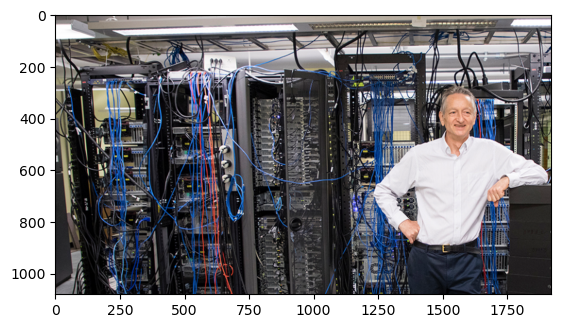

In [24]:
img_path='jeff_hinton.png'
half = 0.5
image = Image.open(img_path)

image.resize( [int(half * s) for s in image.size] )

plt.imshow(image)
plt.show()

We will create a transform object to convert the image to a tensor.


In [25]:
transform = transforms.Compose([transforms.ToTensor()])

We convert the image to a tensor.


In [26]:
img = transform(image)

we can make a prediction,The output is a dictionary with several predicted classes, the probability of belonging to that class and the coordinates of the bounding box corresponding to that class.


In [49]:
pred = model([img])

NameError: name 'img' is not defined

<b>note</b>:  if you call <code>model_([img])</code>  directly but it will use more RAM 


we have the 35  different class predictions, ordered by likelihood scores for potential objects.


In [28]:
pred[0]['labels']

tensor([ 1, 15, 84,  2, 35, 84, 62,  2,  7, 84, 82, 84, 35, 84,  2, 35, 15, 42,
         2, 82, 62, 84, 62, 84,  7,  2, 84,  7,  2,  9, 84, 84,  2, 84,  2])

We have the likelihood of each class:


In [29]:
pred[0]['scores']

tensor([0.9995, 0.3495, 0.2695, 0.2556, 0.2466, 0.1929, 0.1861, 0.1766, 0.1593,
        0.1528, 0.1484, 0.1392, 0.1295, 0.1290, 0.1249, 0.1208, 0.1094, 0.1026,
        0.1023, 0.1019, 0.0846, 0.0827, 0.0826, 0.0794, 0.0785, 0.0738, 0.0735,
        0.0713, 0.0669, 0.0622, 0.0595, 0.0578, 0.0575, 0.0553, 0.0520])

*Note* here we use likelihood as a synonym for probability. Many neural networks output a probability of the output of being a specific class. Here the output is the confidence of  prediction, so we use the term likelihood to distinguish between the two 


The class number corresponds to the index of the list with the corresponding  category name 


In [30]:
index=pred[0]['labels'][0].item()
COCO_INSTANCE_CATEGORY_NAMES[index]

'person'

we have the coordinates of the bounding box


In [31]:
bounding_box=pred[0]['boxes'][0].tolist()
bounding_box

[1223.168701171875, 301.2502136230469, 1909.1724853515625, 1076.6370849609375]

These components correspond to the top-left corner and bottom-right corner of the rectangle,more precisely :
<p>top (t),left (l),bottom(b),right (r)</p>
we need to round them


In [32]:
t,l,r,b=[round(x) for x in bounding_box]

We convert the tensor to an open CV array and plot an image with the box:


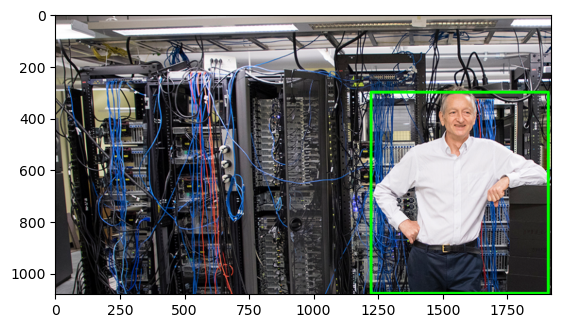

In [33]:
img_plot=(np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8)
cv2.rectangle(img_plot,(t,l),(r,b),(0, 255, 0), 10) # Draw Rectangle with the coordinates
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.show()
del img_plot, t, l, r, b

We can localize objects; we do this using the function 
<code>get_predictions</code>. The input  is the predictions <code>pred</code> and the <code>objects</code> you would like to localize .


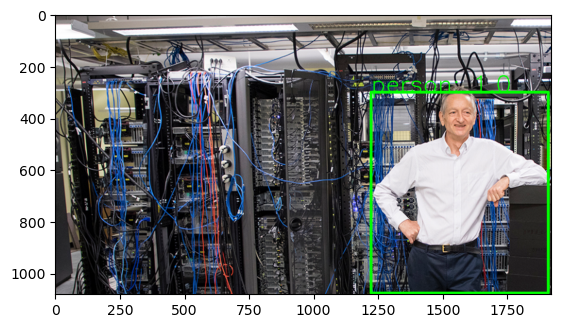

In [34]:
pred_class=get_predictions(pred,objects="person")
draw_box(pred_class, img)
del pred_class

We can set a threshold <code>threshold </code>. Here we set the  threshold 1 i.e Here we set the  threshold 1 i.e. 100% likelihood. 


In [48]:
get_predictions(pred,threshold=1,objects="person")

NameError: name 'pred' is not defined

Here we have no output as the likelihood is not 100%.  Let's try a threshold of 0.98 and use the function  draw_box to draw the box and plot the class and it's rounded likelihood.


In [38]:
pred_thresh=get_predictions(pred,threshold=0.98,objects="person")
draw_box(pred_thresh,img)
del pred_thresh

NameError: name 'pred' is not defined

Delete objects to save memory, we will run this after every cell:


In [39]:
save_RAM(image_=True)

NameError: name 'img' is not defined

We can locate multiple objects, consider the following <a href='https://www.kdnuggets.com/2015/03/talking-machine-deep-learning-gurus-p1.html'>image</a>, we can detect the people in the image.


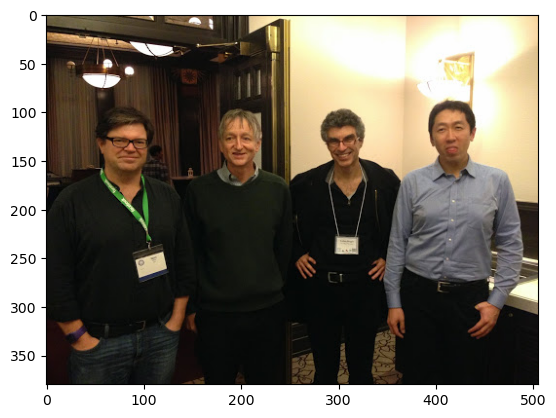

In [47]:
img_path='DLguys.jpeg'
image = Image.open(img_path)
image.resize([int(half * s) for s in image.size])
plt.imshow(np.array(image))
plt.show()

we can set a threshold to detect the object, 0.9 seems to work.


In [40]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.8,)
draw_box(pred_thresh,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_thresh

NameError: name 'image' is not defined

Or we can use objects parameter: 


In [45]:

pred_obj=get_predictions(pred,objects="person")
draw_box(pred_obj,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_obj

NameError: name 'pred' is not defined

If we set the threshold too low, we will detect objects that are not there.


In [46]:
pred_thresh=get_predictions(pred,threshold=0.01)
draw_box(pred_thresh,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_thresh

NameError: name 'pred' is not defined

the following lines will speed up your code by using less RAM.


In [43]:
save_RAM(image_=True)

NameError: name 'img' is not defined

## Object Detection 


In Object Detection we find the classes as well detect the objects in an image. Consider the following <a href="https://www.dreamstime.com/stock-image-golden-retriever-puppy-lying-parakeet-perched-its-head-weeks-old-next-to-british-shorthair-kitten-sitting-image30336051">image</a>


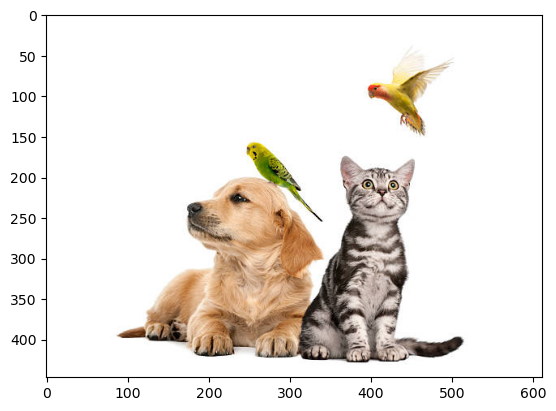

In [50]:
img_path='istockphoto-187786732-612x612.jpeg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

If we set a threshold, we can detect all objects whose likelihood is above that threshold.


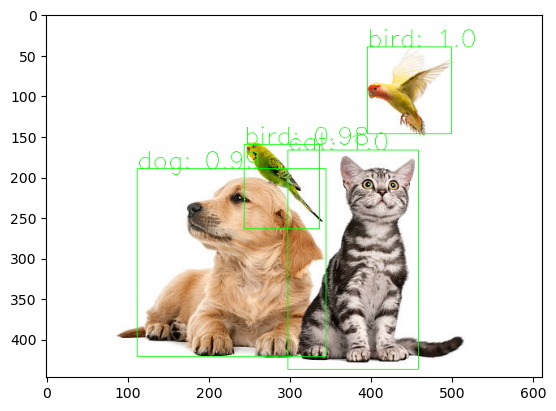

In [51]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.97)
draw_box(pred_thresh,img,rect_th= 1,text_size= 1,text_th=1)
del pred_thresh

the following lines will speed up your code by using less RAM.


In [52]:
 save_RAM(image_=True)

We can specify the objects we would like to classify, for example, cats and dogs:


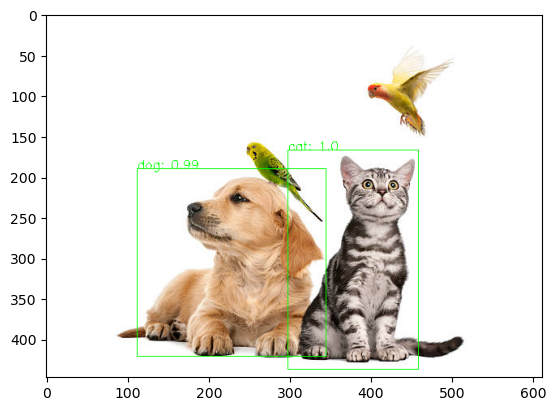

In [53]:
img_path='istockphoto-187786732-612x612.jpeg'
image = Image.open(img_path)
img = transform(image)
pred = model([img])
pred_obj=get_predictions(pred,objects=["dog","cat"])
draw_box(pred_obj,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_obj



In [ ]:
# save_RAM()

If we set the threshold too low, we may detect objects with a low likelihood of being correct; here, we set the threshold to 0.7, and we incorrectly  detect a cat 


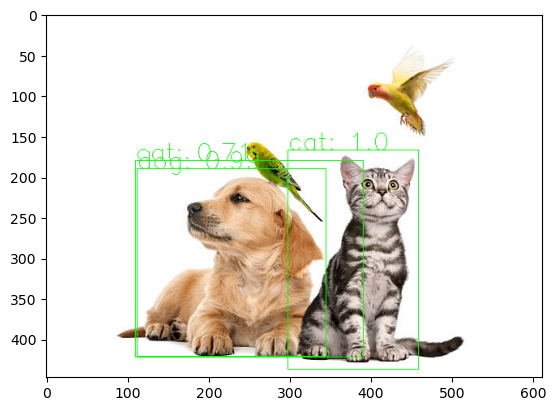

In [54]:
# img = transform(image)
# pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.70,objects=["dog","cat"])
draw_box(pred_thresh,img,rect_th= 1,text_size= 1,text_th=1)
del pred_thresh

In [55]:
save_RAM(image_=True)


We can detect other objects. Consider the following <a href='https://www.flickr.com/photos/watts_photos/27581126637'>image</a>; We can detect cars and airplanes 


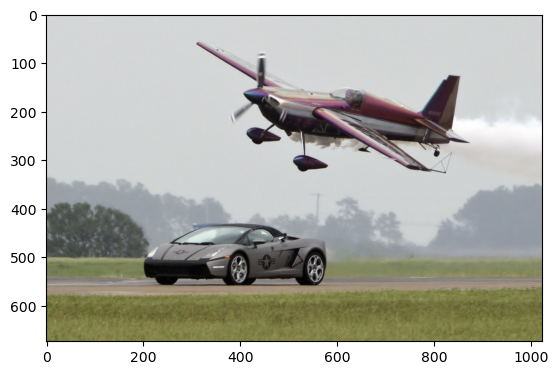

In [56]:
img_path='watts_photos2758112663727581126637_b5d4d192d4_b.jpeg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

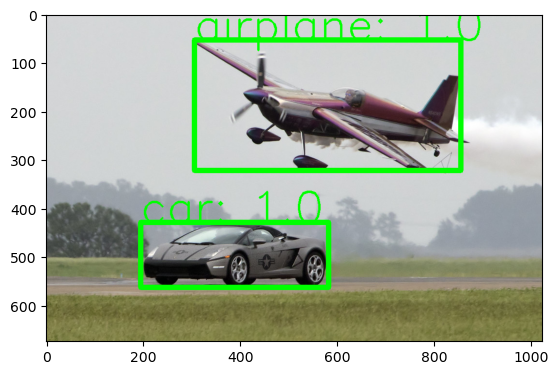

In [57]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.997)
draw_box(pred_thresh,img)
del pred_thresh

In [58]:
save_RAM(image_=True)

## Test Model With An Uploaded Image


You can enter the URL of an image and see if you can detect objects in it . Just remember it must have an image  extension like <code>jpg</code> or <code>png</code>.


In [59]:
url='https://www.plastform.ca/wp-content/themes/plastform/images/slider-image-2.jpg'

We will perform a get request to download the image from the web and convert it to an RGB image. 


In [60]:
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
del url

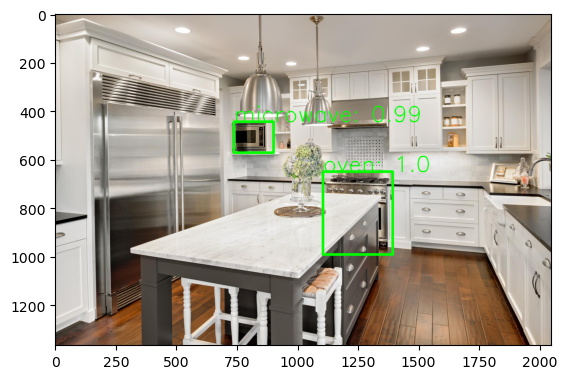

In [61]:
img = transform(image )
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.95)
draw_box(pred_thresh, img)
del pred_thresh

In [62]:
save_RAM(image_=True)

Upload your image, and see if you can detect an object 
<p><b>Instructions on how to upload image:</b></p>
Use the upload button and upload the image from your local machine
<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-SkillsNetwork/images/instruction.png" width="300">
</center>


Replace with the name of your image as seen in your directory


In [ ]:
# img_path='Replace with the name of your image as seen in your directory'
# image = Image.open(img_path) # Load the image
# plt.imshow(np.array(image ))
# plt.show()

detect objects 


In [ ]:
# img = transform(image )
# pred = model(img.unsqueeze(0))
# pred_thresh=get_predictions(pred,threshold=0.95)
# draw_box(pred_thresh,img)

<h2>Authors</h2>


 [Joseph Santarcangelo]( https://www.linkedin.com/in/joseph-s-50398b136/) has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


<h3>Other Contributors</h3>


<a href="contributor_link">Contributor with Link</a>, Contributor No Link


# References 


[1]  Images were taken from: https://homepages.cae.wisc.edu/~ece533/images/
    
[2]  <a href='https://pillow.readthedocs.io/en/stable/index.html'>Pillow Docs</a>

[3]  <a href='https://opencv.org/'>Open CV</a>

[4] Gonzalez, Rafael C., and Richard E. Woods. "Digital image processing." (2017).


<!--<h2>Change Log</h2>-->


<!--<table>
    <tr>
        <th>Date (YYYY-MM-DD)</th>
        <th>Version</th>
        <th>Changed By</th>
        <th>Change Description</th>
    </tr>
    <tr>
        <td>2020-07-20</td>
        <td>0.2</td>
        <td>Joseph Santarcangelo </td>
        <td>Modified Multiple Areas</td>
    </tr>
    <tr>
        <td>2020-07-17</td>
        <td>0.1</td>
        <td>Azim</td>
        <td>Created Lab Template</td>
    </tr>
</table>
-->



<h3 align="center"> &#169; IBM Corporation. All rights reserved. <h3/>
